## Active Learning

Download the titanic dataset here: https://drive.google.com/file/d/0Bz9_0VdXvv9bbVhpOEMwUDJ2elU/view?usp=sharing

In this exercise, we will simulate active learning. We will keep the small sample of observations for testing and we will test how quality of the model rises when we use active learning to choose labeled observations.

In [88]:
# Load the Data into variable df
import pandas as pd
df = pd.read_csv('titanic_dataset.csv')

In [89]:
## Data preparation
## 1.  Drop Cabin as too many null values,drop ticket, name
##2.  Map Embaked to numbers. fillena
##3. fill na Age
##4. Map Sex to number

df['Age'] = df['Age'].fillna(df['Age'].mean())
df.Embarked = df.Embarked.fillna(df.Embarked.mode().iloc[0]).map({'S':0,'C':1,'Q':2})
df.Sex = df.Sex.map({'male':0,'female':1})



In [38]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0


In [90]:
train_col = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
label_col = 'Survived'

In [91]:
# TEST SAMPLE
# USE THIS SAMPLE ONLY FOR TESTING
test_df = df.sample(n=100, random_state=42)
# KEEP ONLY THOSE WHO ARE NOT IN THE TEST SET
df = df[~df.PassengerId.isin(test_df.PassengerId.tolist())]

In [92]:
# FIT THE FIRST MODEL ONLY ON THE DATAFRAME START_DF
start_df = df.sample(n=100, random_state=42)
# DROP OBS FROM START_DF FROM DF
df = df[~df.PassengerId.isin(start_df.PassengerId.tolist())]

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 691 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  691 non-null    int64  
 1   Survived     691 non-null    int64  
 2   Pclass       691 non-null    int64  
 3   Name         691 non-null    object 
 4   Sex          691 non-null    int64  
 5   Age          691 non-null    float64
 6   SibSp        691 non-null    int64  
 7   Parch        691 non-null    int64  
 8   Ticket       691 non-null    object 
 9   Fare         691 non-null    float64
 10  Cabin        165 non-null    object 
 11  Embarked     691 non-null    int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 70.2+ KB


### Tasks

1. fit the first model only on the **start_df** using **SVM** and evaluate accuracy, precision and recall on test_df
2. in each iteration, add 10 observations from **df** to your trainset (choose the observation using active learning approach) 
    - score all observations in df and take 10 where the model isn't sure what class it is. The probability of surviving will be around 50% 
3. refit the model and evaluate on **test_df** again.    
3. the goal is to converge to the optimal solution as fast as possible by choosing **right** observations in each iteration
4. plot the graphs for each eval metric, where on the axis x is iteration number, on y is the metric value for that model

In [93]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

In [94]:
X_train = start_df[train_col]
y_train = start_df[label_col]
X_test = test_df[train_col]
y_test = test_df[label_col]
result_me = pd.DataFrame(columns=['roc_auc','accuracy'])

In [95]:
## use for loop to monitor the results of iteration
for i in range(50):
    
    ## train svm model 
    svm = SVC(probability=True)
    svm.fit(X_train, y_train)
    
    ##record the metrec results
    y_pred = svm.predict(X_test)
    result_me.loc[i,'roc_auc'] = roc_auc_score(y_test,y_pred)
    result_me.loc[i,'accuracy'] = accuracy_score(y_test,y_pred)
    ##early stopper
    if result_me.loc[i,'roc_auc'] > 0.8:
        break
    
    
    ## predict probabilities of rest df records
    X_df = df[train_col]
    y_prob = svm.predict_proba(X_df)

    t = [ y_prob[n,0] * y_prob[n,1] for n in range(len(y_prob))]
    df['prob'] = t
    
    
    ## getting the top 10 lease confident pred_prob records from df to build added dataset
    add10_df = df.sort_values('prob',ascending=False)[:10]
    # DROP OBS FROM add10_DF FROM DF
    df = df[~df.PassengerId.isin(add10_df.PassengerId.tolist())].drop(columns='prob')
    
    
    ## add 10 new records to both X_train and y_train
    X_add = add10_df[train_col]
    y_add = add10_df[label_col]
    X_train = pd.concat([X_train, X_add],ignore_index=True)
    y_train = pd.concat([y_train,y_add],ignore_index=True)   
    
    
    
    

In [99]:
type(result_me.index.to_list())

list

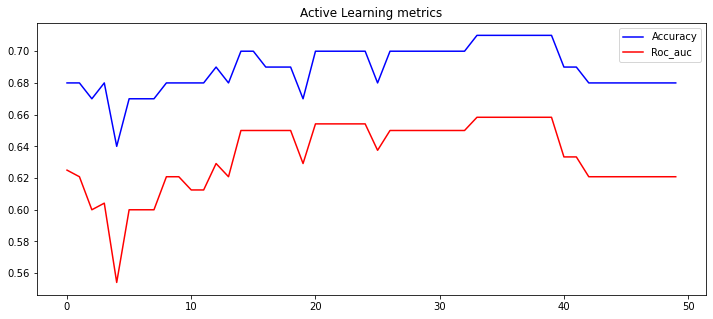

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.plot(result_me.index.to_list(), result_me['accuracy'], 'b', label='Accuracy')
plt.plot(result_me.index.to_list(), result_me['roc_auc'], 'r', label='Roc_auc')

plt.title('Active Learning metrics')
plt.legend()

In [50]:
y_pred = svm.predict(X_test)
print(classification_report(y_test,y_pred))
result = confusion_matrix(y_test,y_pred)
print(roc_auc_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.90      0.77        60
           1       0.70      0.35      0.47        40

    accuracy                           0.68       100
   macro avg       0.69      0.62      0.62       100
weighted avg       0.69      0.68      0.65       100

0.625


In [82]:
y_pred = svm.predict(X_test)
print(classification_report(y_test,y_pred))
result = confusion_matrix(y_test,y_pred)
print(roc_auc_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.66      0.95      0.78        60
           1       0.77      0.25      0.38        40

    accuracy                           0.67       100
   macro avg       0.71      0.60      0.58       100
weighted avg       0.70      0.67      0.62       100

0.6
